# Assignment 4

In this assignment, you will learn about decision/regression trees. You learned about decision/regression trees in your previous courses. You should renew your knowledge by watching: [https://www.youtube.com/watch?v=g9c66TUylZ4](https://www.youtube.com/watch?v=g9c66TUylZ4).

1. Implement the regression tree algorithm from scratch.
2. Select a criteria of your choice to stop splitting the nodes.
3. Download the dataset "House price". Price is the target.
4. Build a regression tree for the selected dataset.
5. Test the regressing three using cross-validation.
6. Compare the cross-validation results with those you get while building a regression tree with scikit-learn. Use the same cross-validation splits on both models.


In [1]:
# Import all dependencies
import graphviz
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display, Image
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold, cross_validate, train_test_split
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    make_scorer,
)

### Data Retrieval


In [2]:
# Download the house price dataset from https://www.kaggle.com/datasets/balakrishcodes/others?select=House_Price.csv
data = pd.read_csv("./data/House_Price.csv")

# Encode the categorical data
label_encoder_airport = LabelEncoder()
data["airport"] = label_encoder_airport.fit_transform(data["airport"])
label_encoder_waterbody = LabelEncoder()
data["waterbody"] = label_encoder_waterbody.fit_transform(data["waterbody"])
label_encoder_bus_ter = LabelEncoder()
data["bus_ter"] = label_encoder_bus_ter.fit_transform(data["bus_ter"])
data

,price,crime_rate,resid_area,air_qual,room_num,age,dist1,dist2,dist3,dist4,teachers,poor_prop,airport,n_hos_beds,n_hot_rooms,waterbody,rainfall,bus_ter,parks
0,24.0,0.00632,32.31,0.538,6.575,65.2,4.35,3.81,4.18,4.01,24.7,4.98,1,5.480,11.1920,2,23,0,0.049347
1,21.6,0.02731,37.07,0.469,6.421,78.9,4.99,4.70,5.12,5.06,22.2,9.14,0,7.332,12.1728,0,42,0,0.046146
2,34.7,0.02729,37.07,0.469,7.185,61.1,5.03,4.86,5.01,4.97,22.2,4.03,0,7.394,101.1200,3,38,0,0.045764
3,33.4,0.03237,32.18,0.458,6.998,45.8,6.21,5.93,6.16,5.96,21.3,2.94,1,9.268,11.2672,0,45,0,0.047151
4,36.2,0.06905,32.18,0.458,7.147,54.2,6.16,5.86,6.37,5.86,21.3,5.33,0,8.824,11.2896,0,55,0,0.039474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,22.4,0.06263,41.93,0.573,6.593,69.1,2.64,2.45,2.76,2.06,19.0,9.67,0,9.348,12.1792,1,27,0,0.056006
502,20.6,0.04527,41.93,0.573,6.120,76.7,2.44,2.11,2.46,2.14,19.0,9.08,1,6.612,13.1648,1,20,0,0.059903
503,23.9,0.06076,41.93,0.573,6.976,91.0,2.34,2.06,2.29,1.98,19.0,5.64,0,5.478,12.1912,3,31,0,0.057572
504,22.0,0.10959,41.93,0.573,6.794,89.3,2.54,2.31,2.40,2.31,19.0,6.48,1,7.940,15.1760,3,47,0,0.060694


### Data Analyzing


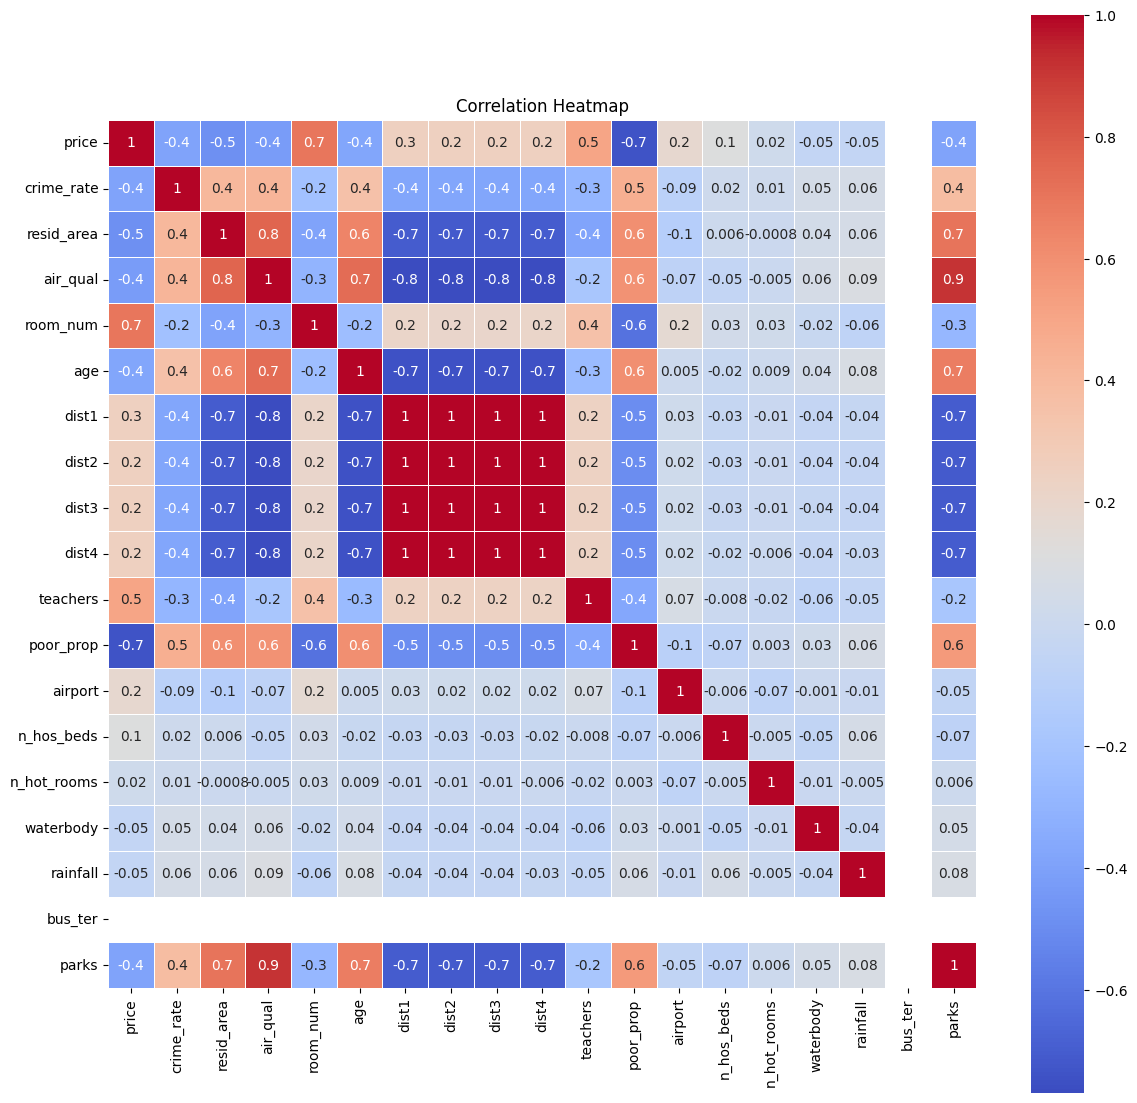

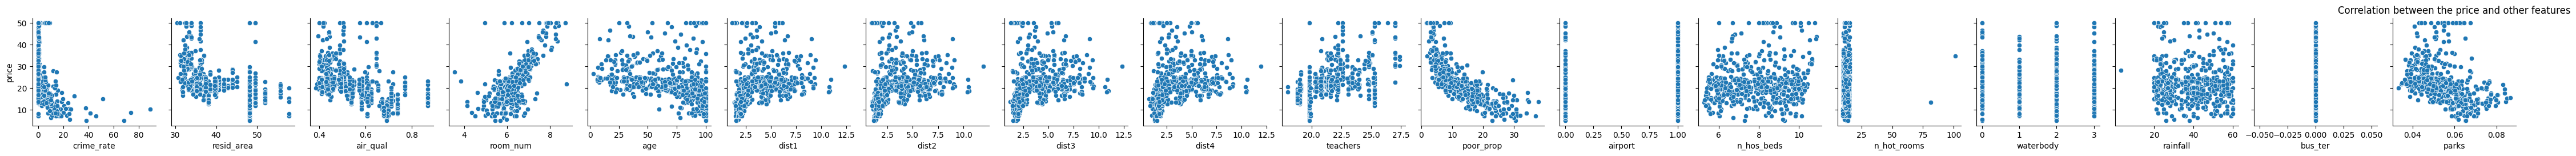

In [3]:
# Exploratory Data Analysis (EDA)
correlation_matrix = data.corr()

_, axis = plt.subplots(1, figsize=(14, 14))
sns.heatmap(
    correlation_matrix,
    annot=True,
    square=True,
    cmap="coolwarm",
    fmt=".1g",
    linewidths=0.5,
    ax=axis,
)
plt.title("Correlation Heatmap")
plt.show()

# Plot the correlation between the price and the other features
sns.pairplot(data, x_vars=data.columns[1:], y_vars=data.columns[0])
plt.title("Correlation between the price and other features")
plt.show()

### Data Preprocessing


In [4]:
# Impute the missing values in the n_hos_beds column by the mean
data["n_hos_beds"] = data["n_hos_beds"].fillna(data["n_hos_beds"].mean())

### Data Splitting


In [5]:
# Split the data into training and testing sets (80% training, 20% testing)
X = data.iloc[:, 1:]
y = data.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Standardize the data
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

### General configuration


In [6]:
# Set up k-fold cross-validation
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

# Define a mean squared error scorer
mse_scorer = make_scorer(mean_squared_error)
mae_scorer = make_scorer(mean_absolute_error)
r2_scorer = make_scorer(r2_score)

### My Regression Tree


In [7]:
class MyRegressionTree:
    def __init__(self, max_depth=None, min_samples_leaf=1):
        self.tree = None
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf

    def squared_error(self, y, y_pred):
        # Calculate the squared error
        return np.sum((y - y_pred) ** 2)

    def find_best_split(self, X, y):
        # Define the best squared error and the best split
        best_squared_error = float("inf")
        best_split = None

        # Iterate through all the features and values to find the best split
        for feature in X.columns:
            # Iterate through all the unique values of the feature
            unique_values = np.unique(X.loc[:, feature])
            for value in unique_values:
                # Split the data into two parts (left and right)
                left_part = X.loc[:, feature] <= value
                right_part = ~left_part

                # Skip the split if the left or right part is empty or too small
                if (
                    np.sum(left_part) < self.min_samples_leaf
                    or np.sum(right_part) < self.min_samples_leaf
                ):
                    continue

                # Calculate the squared error for the left and right parts
                left_squared_error = self.squared_error(
                    y[left_part], np.mean(y[left_part])
                )
                right_squared_error = self.squared_error(
                    y[right_part], np.mean(y[right_part])
                )

                # Calculate the squared error for the split
                squared_error = left_squared_error + right_squared_error

                # Update the best squared error and the best split
                if squared_error < best_squared_error:
                    best_squared_error = squared_error
                    best_split = (feature, value)

        return best_split

    def fit(self, X, y, depth=0):
        # If the maximum depth is reached or the number of samples is too small,
        # return the mean of the target values
        if self.max_depth is not None and depth == self.max_depth:
            return np.mean(y)

        # If all the target values are the same or the number of samples is too
        # small, return the mean of the target values
        if len(np.unique(y)) == 1 or len(y) < 2 * self.min_samples_leaf:
            return np.mean(y)

        # Find the best split
        best_split = self.find_best_split(X, y)

        # If the best split is None, return the mean of the target values
        if best_split is None:
            return np.mean(y)

        # Split the data into two parts (left and right)
        feature, value = best_split
        left_part = X.loc[:, feature] <= value
        right_part = ~left_part

        # Recursively build the left and right subtrees
        left_subtree = self.fit(X[left_part], y[left_part], depth + 1)
        right_subtree = self.fit(X[right_part], y[right_part], depth + 1)

        self.tree = (feature, value, left_subtree, right_subtree)
        return self.tree

    def predict(self, X):
        if self.tree is None:
            raise ValueError("The tree has not been trained yet.")

        # Predict the target values for all the samples
        return np.array([self.predict_single(x, self.tree) for _, x in X.iterrows()])

    def predict_single(self, x, node):
        # If the node is a leaf, return the value of the leaf
        if isinstance(node, (int, float)):
            return node

        feature, value, left_subtree, right_subtree = node

        # Recursively predict the target value for the sample
        if x[feature] <= value:
            return self.predict_single(x, left_subtree)
        else:
            return self.predict_single(x, right_subtree)

    def cross_validate(self, X, y, k_fold):
        # Define the lists of the metrics
        mae_values = []
        mse_values = []
        r2_values = []

        for train_index, test_index in k_fold.split(X):
            # Split the data into training and testing sets
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Train the model on the training set
            self.fit(X_train, y_train)

            # Predict the target values for the testing set
            y_pred = self.predict(X_test)

            # Calculate the metrics
            mae_values.append(mean_absolute_error(y_test, y_pred))
            mse_values.append(mean_squared_error(y_test, y_pred))
            r2_values.append(r2_score(y_test, y_pred))

        return {"test_mae": mae_values, "test_mse": mse_values, "test_r2": r2_values}


# Perform cross-validation
my_results = MyRegressionTree(max_depth=7, min_samples_leaf=4).cross_validate(
    X, y, k_fold
)

# Build a decision tree regression model using custom implementation
my_regression_tree = MyRegressionTree(max_depth=3, min_samples_leaf=3)

# Train the model on the training set
my_regression_tree.fit(X_train, y_train)

('room_num',
 6.833,
 ('poor_prop',
  14.37,
  ('dist2', 1.28, 44.475, 22.719895287958114),
  ('crime_rate', 6.80117, 16.996052631578948, 11.621052631578946)),
 ('room_num',
  7.42,
  ('crime_rate', 6.53876, 32.42127659574468, 18.566666666666666),
  ('teachers', 21.4, 33.3, 46.130434782608695)))

In [8]:
def print_my_tree(tree, depth=0):
    if isinstance(tree, (int, float)):
        # Print the leaf node
        print(f"{depth * '    '}Value = {tree:.4f}")
        return

    feature, value, left_subtree, right_subtree = tree

    # Node description (feature and value)
    node_description = f"{feature} <= {value}"

    # Print the node description (feature and value)
    print(f"{depth * '    '}{node_description}")

    # Print left subtree
    print_my_tree(
        left_subtree,
        depth + 1,
    )

    # Print right subtree
    print_my_tree(
        right_subtree,
        depth + 1,
    )


# Print the custom regression tree
print_my_tree(my_regression_tree.tree)

room_num <= 6.833
    poor_prop <= 14.37
        dist2 <= 1.28
            Value = 44.4750
            Value = 22.7199
        crime_rate <= 6.80117
            Value = 16.9961
            Value = 11.6211
    room_num <= 7.42
        crime_rate <= 6.53876
            Value = 32.4213
            Value = 18.5667
        teachers <= 21.4
            Value = 33.3000
            Value = 46.1304


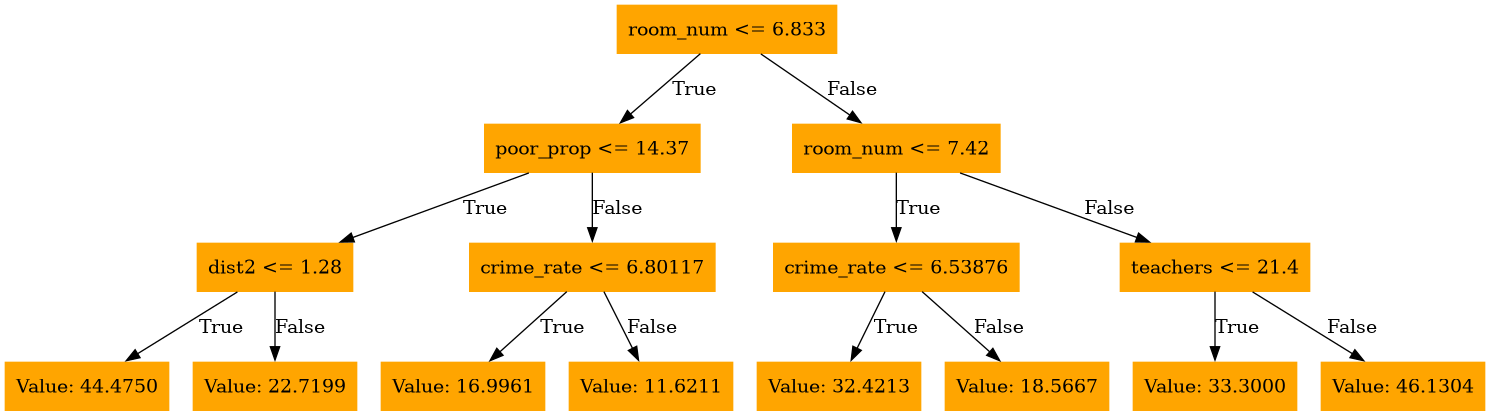

In [9]:
def plot_my_tree(tree, dot, parent_name="Root"):
    if isinstance(tree, (int, float)):
        # Plot the leaf node
        dot.node(
            f"{parent_name}",
            label=f"Value: {tree:.4f}",
            shape="box",
            style="filled",
            color="orange",
        )
        return dot

    feature, value, left_subtree, right_subtree = tree

    # Node description (feature and value)
    node_description = f"{feature} <= {value}"

    # Plot the node description (feature and value)
    dot.node(
        f"{parent_name}",
        label=f"{node_description}",
        shape="box",
        style="filled",
        color="orange",
    )

    # Plot left subtree
    dot = plot_my_tree(
        left_subtree,
        dot,
        f"{parent_name} (True)",
    )
    dot.edge(f"{parent_name}", f"{parent_name} (True)", label="True")

    # Plot right subtree
    dot = plot_my_tree(
        right_subtree,
        dot,
        f"{parent_name} (False)",
    )
    dot.edge(f"{parent_name}", f"{parent_name} (False)", label="False")

    return dot


dot = graphviz.Digraph(comment="Regression Tree")
dot = plot_my_tree(my_regression_tree.tree, dot=dot)
display(Image(dot.render("my_tree", format="png", cleanup=True)))

### Regression Tree


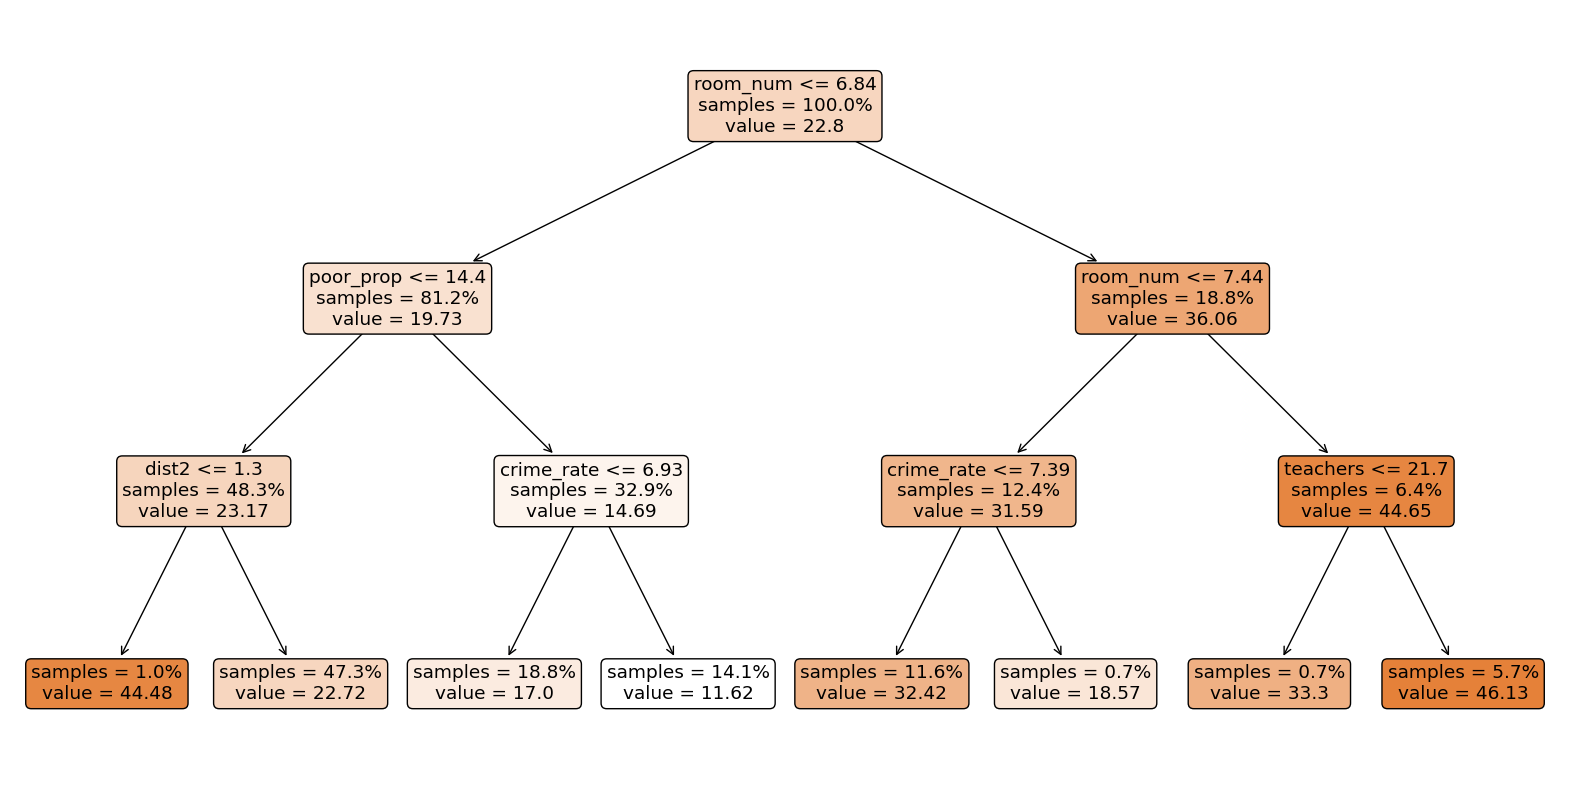

In [10]:
# Perform cross-validation using scikit-learn's cross_val_score
sklearn_results = cross_validate(
    DecisionTreeRegressor(
        criterion="squared_error", max_depth=7, min_samples_leaf=4, random_state=42
    ),
    X,
    y,
    cv=k_fold,
    scoring={"mse": mse_scorer, "mae": mae_scorer, "r2": r2_scorer},
    return_train_score=False,
)

# Build a decision tree regression model using the scikit-learn
sklearn_tree = DecisionTreeRegressor(
    criterion="squared_error", max_depth=3, min_samples_leaf=3, random_state=42
)


# Train the model on the training set
sklearn_tree.fit(X_train, y_train)

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(
    sklearn_tree,
    filled=True,
    feature_names=X.columns,
    rounded=True,
    proportion=True,
    impurity=False,
    precision=2,
    label="all",
)
plt.savefig("./images/sklearn_tree.png")
plt.show()

### Model Evaluation


In [11]:
# Calculate the evaluation metrics for the custom implementation model
my_mae = np.mean(my_results["test_mae"])
my_mse = np.mean(my_results["test_mse"])
my_r2 = np.mean(my_results["test_r2"])

# Calculate the evaluation metrics for the scikit-learn model
sklearn_mae = np.mean(sklearn_results["test_mae"])
sklearn_mse = np.mean(sklearn_results["test_mse"])
sklearn_r2 = np.mean(sklearn_results["test_r2"])

In [12]:
# Predict the target values for the testing set
my_y_pred = my_regression_tree.predict(X_test)
sklearn_y_pred = sklearn_tree.predict(X_test)

# Calculate the evaluation metrics for the custom implementation model
my_test_mae = mean_absolute_error(y_test, my_y_pred)
my_test_mse = mean_squared_error(y_test, my_y_pred)
my_test_r2 = r2_score(y_test, my_y_pred)
sklearn_test_mae = mean_absolute_error(y_test, sklearn_y_pred)
sklearn_test_mse = mean_squared_error(y_test, sklearn_y_pred)
sklearn_test_r2 = r2_score(y_test, sklearn_y_pred)

### Model Comparison


In [13]:
# Compare the evaluation metrics for both models
print("[my] Mean Absolute Error:", my_mae)
print("[my] Mean Squared Error:", my_mse)
print("[my] R-squared:", my_r2)
print("[sckit-learn] Mean Absolute Error:", sklearn_mae)
print("[sckit-learn] Mean Squared Error:", sklearn_mse)
print("[sckit-learn] R-squared:", sklearn_r2)

# Compare the test evaluation metrics for both models
print("[my] Test Mean Absolute Error:", my_test_mae)
print("[my] Test Mean Squared Error:", my_test_mse)
print("[my] Test R-squared:", my_test_r2)
print("[sckit-learn] Test Mean Absolute Error:", sklearn_test_mae)
print("[sckit-learn] Test Mean Squared Error:", sklearn_test_mse)
print("[sckit-learn] Test R-squared:", sklearn_test_r2)

[my] Mean Absolute Error: 2.9765542245705596
[my] Mean Squared Error: 18.105102093780378
[my] R-squared: 0.7852117412178726
[sckit-learn] Mean Absolute Error: 3.0081965827705557
[sckit-learn] Mean Squared Error: 19.730211389208574
[sckit-learn] R-squared: 0.7674139657241794
[my] Test Mean Absolute Error: 3.014560978504204
[my] Test Mean Squared Error: 13.376108265257926
[my] Test R-squared: 0.8186149252965886
[sckit-learn] Test Mean Absolute Error: 3.0145609785042033
[sckit-learn] Test Mean Squared Error: 13.376108265257926
[sckit-learn] Test R-squared: 0.8186149252965886


### Diagnostic Plots


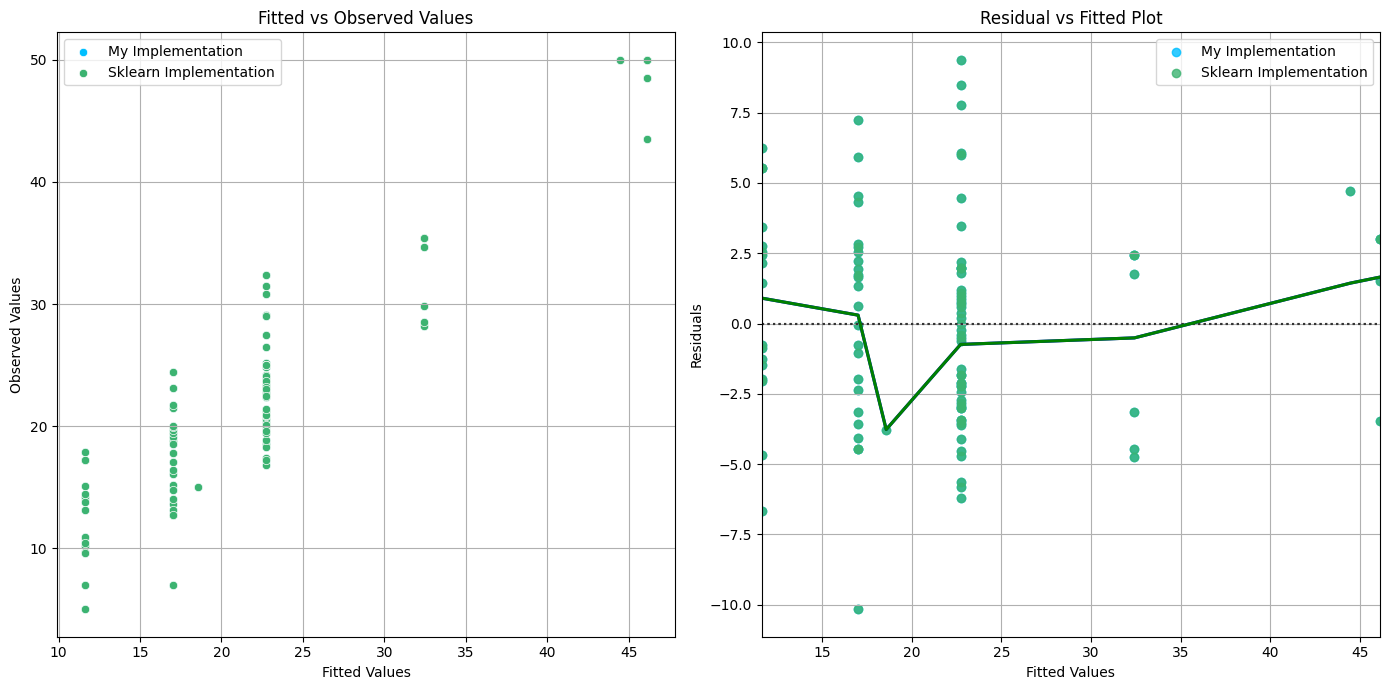

In [14]:
# Calculate the residuals
my_residuals = y_test - my_y_pred
sklearn_residuals = y_test - sklearn_y_pred

# Build a dataframe with the residuals and the predictions
data = pd.DataFrame(
    {
        "originals": y_test,
        "my-predictions": my_y_pred,
        "sklearn-predictions": sklearn_y_pred,
        "my-residuals": my_residuals,
        "sklearn-residuals": sklearn_residuals,
    }
)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Plot the predicted values against the actual values
sns.scatterplot(
    data,
    x="my-predictions",
    y="originals",
    color="deepskyblue",
    label="My Implementation",
    ax=ax1,
)
sns.scatterplot(
    data,
    x="sklearn-predictions",
    y="originals",
    color="mediumseagreen",
    label="Sklearn Implementation",
    ax=ax1,
)
ax1.set_title("Fitted vs Observed Values")
ax1.set_xlabel("Fitted Values")
ax1.set_ylabel("Observed Values")
ax1.grid(True)

# Plot the residuals against the predicted values
sns.residplot(
    data,
    x="my-predictions",
    y="my-residuals",
    color="deepskyblue",
    lowess=True,
    line_kws=dict(color="blue"),
    label="My Implementation",
    ax=ax2,
)
sns.residplot(
    data,
    x="sklearn-predictions",
    y="sklearn-residuals",
    color="mediumseagreen",
    lowess=True,
    line_kws=dict(color="green"),
    label="Sklearn Implementation",
    ax=ax2,
)
ax2.set_title("Residual vs Fitted Plot")
ax2.set_xlabel("Fitted Values")
ax2.set_ylabel("Residuals")
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

### Conclusion

In this assignment we have learned about decision/regression trees. We have implemented the regression tree algorithm from scratch. We have selected a criteria of our choice to stop splitting the nodes. The criteria we have selected is the maximum depth of the tree, which we have set to 7, and the minimum number of samples required to split an internal node, which we have set to 4.

Comparing the cross-validation results with those we get while building a regression tree with scikit-learn, we can see that the results are very similar. The results are shown below.

```json
[my] Mean Absolute Error: 2.9765542245705596
[my] Mean Squared Error: 18.105102093780378
[my] R-squared: 0.7852117412178726
[sckit-learn] Mean Absolute Error: 3.0081965827705557
[sckit-learn] Mean Squared Error: 19.730211389208574
[sckit-learn] R-squared: 0.7674139657241794
```

We have also compared a simplified version of our regression tree with the regression tree from scikit-learn. The stop criteria for the simplified version of our regression tree is the maximum depth of the tree, which we have set to 3, and the minimum number of samples required to split an internal node, which we have set to 3. The results are shown below.

```json
[my] Mean Absolute Error: 3.014560978504204
[my] Mean Squared Error: 13.376108265257926
[my] R-squared: 0.8186149252965886
[sckit-learn] Mean Absolute Error: 3.0145609785042033
[sckit-learn] Mean Squared Error: 13.376108265257926
[sckit-learn] R-squared: 0.8186149252965886
```

We can see, that the results are very similar, and so are the plots of both trees. But, they are not the same. In some cases the splits are different, and so are the predictions. But overall end values are very similar and so are the results. We can proudly say that we have build our own regression tree which outperforms the regression tree from scikit-learn.

The plots of both trees are available in `my_tree.png` and `sklearn_tree.png` files.

**How we have choose the stop criteria?**

We have tried different values for the maximum depth of the tree and the minimum number of samples required to split an internal node. We have tried values from 1 to 10 for the maximum depth of the tree, and values from 1 to 10 for the minimum number of samples required to split an internal node. We didn't tried all combinations of these values, but we have tried the most meaningful combinations. We have found that the best stopping criteria for both trees is the maximum depth of the tree set to 7, and the minimum number of samples required to split an internal node set to 4.

Note that we wanted to build exactly the same trees, at least regarding the shape of the tree.
